### 1.0 Importing the data, required libraries,Dataset shape

In [1]:
# Importing the data into Pandas dataframe
import pandas as pd
df = pd.read_csv('df_twitter.csv')
df.head()

Unnamed: 0                                             tweets     hashtag
0           0  one's mind moves mountains stephen cherokee dr...      travel
1           1  sizing scylla cluster learn calculate cpu ram ...      python
2           2                          birthday bash realmeindia     fitness
3           3  winning candidate president white male known e...     fitness
4           4                              journey python golang  healthcare

In [2]:
df.shape

(164480, 3)

In [3]:
# This cell is used for iterative model development process
#Currently only 20000 tweets are considered for training due to the memory the machine consumes

df=df.head(20000)

In [4]:
#Number of unique hashtags (labels)
df.hashtag.unique()

array(['travel', 'python', 'fitness', 'healthcare', 'history', 'research',
       'politics', 'books', 'tensorflow', 'docker', 'aws', 'dash',
       'nosql', 'flask', 'plotly'], dtype=object)

### 2.0 Data exploration

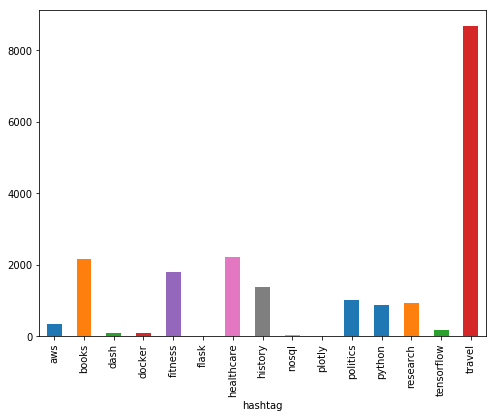

In [194]:
#Distribution of the hashtags

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('hashtag').tweets.count().plot.bar(ylim=0)
plt.show()

The tweets hashtags are highly imbalanced while being skewed towards few some specific hashtags.

### 3. 0 Data pre-processing

In [195]:
#Data Pre-processing
from io import StringIO
col = ['hashtag', 'tweets']
df = df[col]

#Removing the empty content (Ideally, the model must not predict anything)
df = df[pd.notnull(df['tweets'])]
df.columns = ['hashtag', 'tweets']

#Converting to the numeric (i.e categorization of hashtags) and sorting after removing duplicates
df['category_id'] = df['hashtag'].factorize()[0]
category_id_df = df[['hashtag', 'category_id']].drop_duplicates().sort_values('category_id')

#Adding them to the pandas dataframe as dictionary
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'hashtag']].values)
df.head()

hashtag                                             tweets  category_id
0      travel  one's mind moves mountains stephen cherokee dr...            0
1      python  sizing scylla cluster learn calculate cpu ram ...            1
2     fitness                          birthday bash realmeindia            2
3     fitness  winning candidate president white male known e...            2
4  healthcare                              journey python golang            3

The statistical models typilcally requires the numeric inputs to learn from. The following step is used to convert the texts into the numerics using TF-IDF method.It is one of the extensively used in the text based information extraction applications and here the same was applied.

In [196]:
#Features transformation from text to Numeric

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='latin-1', ngram_range=(1,2), stop_words='english')
features = tfidf.fit_transform(df.tweets).toarray()
labels = df.category_id
features.shape

(19805, 25466)

The above implies that the 9906 number of tweets are converted into 14141 unique features.

#### Viewing correlated words for hashtags

In [197]:
#Extracting the highly correlated terms/words for each hashtag
#This step will help us to intutiveley look at the words which are highly closer to the hashtag

from sklearn.feature_selection import chi2
import numpy as np
N = 2
for hashtag,category_id in sorted(category_to_id.items()):
  features_chi2=chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(hashtag))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'aws':
  . Most correlated unigrams:
. advicetowriters
. dressy
  . Most correlated bigrams:
. dressy ones
. papers news
# 'books':
  . Most correlated unigrams:
. alyssuhlove
. bear
  . Most correlated bigrams:
. headlines thanks
. think like
# 'dash':
  . Most correlated unigrams:
. surreal
. sons
  . Most correlated bigrams:
. dare play
. systems engineer
# 'docker':
  . Most correlated unigrams:
. ebay
. hero
  . Most correlated bigrams:
. experienced professional
. check home
# 'fitness':
  . Most correlated unigrams:
. neat
. charm
  . Most correlated bigrams:
. neat barn
. finally updated
# 'flask':
  . Most correlated unigrams:
. lawyers
. explosive
  . Most correlated bigrams:
. border detention
. detention site
# 'healthcare':
  . Most correlated unigrams:
. inn
. thrills
  . Most correlated bigrams:
. places visit
. workourt life
# 'history':
  . Most correlated unigrams:
. divine
. bayada
  . Most correlated bigrams:
. amp supply
. good ladies
# 'nosql':
  . Most correlat

## 4.0 Models

### 4.1 Simple Model - Naive Baise Classifier 

Naive Baive classifier is one of the probability based learer which suits the application for text classification. NB is considered here as basic model (as first iteration).

In [198]:
#Simple Model - NB Classifier

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#Splitting into train and testing data
X_train, X_test, y_train, y_test = train_test_split(df['tweets'], df['hashtag'], random_state = 0)

#Features transformation - tf-idf vectorizer i.e equivalent to Count vectorizer followed by tranformer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#Training the classifier
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [199]:
print (X_train.shape,y_train.shape)

(14853,) (14853,)


#### Testing samples (of tweets) 

In [200]:
print(clf.predict(count_vect.transform(["bus medicine"])))

['travel']


### 4.2 Candidate models

The following models were used in addition to the base model towards improving the complexity.
1. Support Vector Machines
2. Ensemble Model - Random forest Classifier

C:\Users\LN86VMd\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\LN86VMd\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\LN86VMd\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


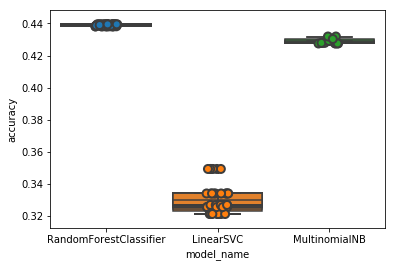

In [201]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC 
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),MultinomialNB()
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
        import seaborn as sns
        sns.boxplot(x='model_name', y='accuracy', data=cv_df)
        sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

### 4.3 Performance measure

In [202]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.331537
MultinomialNB             0.429388
RandomForestClassifier    0.438981
Name: accuracy, dtype: float64

## 5.0 Dealing with Imbalanced data